In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to compute Gram-a-Tonegram
def compute_gram_tonegram(audio, sr, n_fft=2048, hop_length=512):
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    tonegram = np.abs(stft)  # Magnitude spectrum
    return tonegram

# Function to save the Gram-a-Tonegram as an image
def save_tonegram_image(tonegram, sr, hop_length, output_file):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(
        librosa.amplitude_to_db(tonegram, ref=np.max), 
        sr=sr, hop_length=hop_length, x_axis='time', y_axis='log'
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title('Gram-a-Tonegram')
    plt.tight_layout()
    plt.savefig(output_file, format='png')  # Save as PNG
    plt.close()

# Function to process a single genre
def process_genre(dataset_path, output_path, genre, sr=22050, n_fft=2048, hop_length=512):
    """
    Process all audio files in a single genre folder and save Gram-a-Tonegram images.
    
    Args:
        dataset_path (str): Path to the dataset root directory.
        output_path (str): Path to save generated images.
        genre (str): The genre folder to process.
        sr (int): Sampling rate for audio files.
        n_fft (int): FFT window size.
        hop_length (int): Hop length for FFT.
    """
    genre_path = os.path.join(dataset_path, genre)
    genre_output_path = os.path.join(output_path, genre)
    os.makedirs(genre_output_path, exist_ok=True)

    # Process each audio file in the genre folder
    audio_files = [f for f in os.listdir(genre_path) if f.endswith(('.wav', '.mp3'))]
    for audio_file in tqdm(audio_files, desc=f"Processing {genre}"):
        file_path = os.path.join(genre_path, audio_file)
        try:
            # Load the audio file
            audio, sr = librosa.load(file_path, sr=sr)

            # Compute the tonegram
            tonegram = compute_gram_tonegram(audio, sr, n_fft=n_fft, hop_length=hop_length)

            # Save the tonegram as an image
            output_file = os.path.join(genre_output_path, os.path.splitext(audio_file)[0] + ".png")
            save_tonegram_image(tonegram, sr, hop_length, output_file)
        except Exception as e:
            tqdm.write(f"Error processing {file_path}: {e}")

# Example usage
dataset_path = r"F:\music genre\myenv\genres_original"  # Path to the dataset
output_path = r"F:\music genre\myenv\gram_tonegram_images"  # Path to save images

# List genres and allow the user to process one at a time
genres = [g for g in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, g))]
print("Available genres:")
for idx, genre in enumerate(genres):
    print(f"{idx + 1}. {genre}")

# Get user input to select a genre
genre_idx = int(input("Enter the number corresponding to the genre you want to process: ")) - 1
if 0 <= genre_idx < len(genres):
    selected_genre = genres[genre_idx]
    print(f"Processing genre: {selected_genre}")
    process_genre(dataset_path, output_path, selected_genre)
else:
    print("Invalid selection. Please try again.")


In [3]:
import os
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.neighbors import NearestNeighbors

# Function to load images and labels
def load_images(image_dir, img_size=(224, 224)):  # ResNet50 requires input size (224, 224)
    """
    Load images and their labels from a directory.
    Args:
        image_dir (str): Path to the directory containing genre folders with images.
        img_size (tuple): Size to resize images for the model.
    Returns:
        X (np.array): Image data.
        y (list): Labels.
    """
    X, y = [], []
    genres = [g for g in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, g))]
    for label, genre in enumerate(genres):
        genre_path = os.path.join(image_dir, genre)
        for img_file in os.listdir(genre_path):
            if img_file.endswith('.png'):
                img_path = os.path.join(genre_path, img_file)
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img)
                X.append(img_array)
                y.append(label)
    return np.array(X), np.array(y)

# Function to save features and labels
def save_features_and_labels(features, labels, feature_file, label_file):
    """
    Save extracted features and labels as numpy files.
    Args:
        features (np.array): Extracted features.
        labels (np.array): Labels corresponding to features.
        feature_file (str): Path to save features file.
        label_file (str): Path to save labels file.
    """
    np.save(feature_file, features)
    np.save(label_file, labels)

# Function to manually apply SMOTE
def manual_smote(X, y, k_neighbors=5, random_state=None, target_class_size=None):
    """
    Manually apply SMOTE to oversample the minority classes.
    Args:
        X (np.array): Feature data.
        y (np.array): Labels.
        k_neighbors (int): Number of nearest neighbors to use for SMOTE.
        random_state (int): Random seed for reproducibility.
        target_class_size (int): Target number of samples for each class, if you want to control this.
    Returns:
        X_resampled (np.array): Resampled feature data with synthetic samples.
        y_resampled (np.array): Resampled labels corresponding to X_resampled.
    """
    np.random.seed(random_state)
    classes, class_counts = np.unique(y, return_counts=True)
    
    # If target_class_size is specified, use it, otherwise use the max class count
    max_class_count = target_class_size if target_class_size else max(class_counts)
    
    X_resampled = X.copy()
    y_resampled = y.copy()

    # Loop through each class
    for class_label in classes:
        # Find all samples of the current class
        class_indices = np.where(y == class_label)[0]
        class_samples = X[class_indices]

        # Number of synthetic samples to create
        num_samples_to_create = max_class_count - len(class_samples)

        if num_samples_to_create > 0:
            # Nearest neighbors to generate synthetic samples
            knn = NearestNeighbors(n_neighbors=k_neighbors)
            knn.fit(class_samples)
            
            # Create synthetic samples
            synthetic_samples = []
            for _ in range(num_samples_to_create):
                idx = np.random.choice(len(class_samples))
                neighbors = knn.kneighbors([class_samples[idx]], n_neighbors=k_neighbors)[1][0]
                neighbor_idx = np.random.choice(neighbors[1:])  # Avoid the sample itself
                synthetic_sample = class_samples[idx] + np.random.rand() * (class_samples[neighbor_idx] - class_samples[idx])
                synthetic_samples.append(synthetic_sample)

            # Add synthetic samples to the resampled dataset
            X_resampled = np.vstack((X_resampled, synthetic_samples))
            y_resampled = np.hstack((y_resampled, [class_label] * num_samples_to_create))

    return X_resampled, y_resampled

# Paths and parameters
image_dir = r"F:\music genre\myenv\gram_tonegram_images"
feature_file = "featuresfromresnet50.npy"
label_file = "labelsfromresnet50.npy"

# Load images and labels
X, y = load_images(image_dir)

# Preprocess images for ResNet50
X = preprocess_input(X)

# Extract features using ResNet50
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
features = resnet50.predict(X, verbose=1)

# Flatten features for SMOTE
features_flat = features.reshape(features.shape[0], -1)

# Manually apply SMOTE to generate more synthetic data (e.g., double the dataset size for each genre)
features_smote, labels_smote = manual_smote(features_flat, y, k_neighbors=5, random_state=42, target_class_size=200)

# Save features and labels (original + synthetic)
save_features_and_labels(features_smote, labels_smote, feature_file, label_file)

print(f"Features saved to {feature_file}")
print(f"Labels saved to {label_file}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step
Features saved to featuresfromresnet50.npy
Labels saved to labelsfromresnet50.npy


In [1]:
import numpy as np

# Load features and labels
features = np.load("featuresfromresnet50.npy")
labels = np.load("labelsfromresnet50.npy")

# Check the shape of the loaded data
print(features.shape)  # Should be (num_samples, num_features)
print(labels.shape)    # Should be (num_samples,)


(2000, 100352)
(2000,)


In [2]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape)


(1600, 100352) (400, 100352)


In [3]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build the model
model = Sequential()

# Add a fully connected (dense) layer with L2 regularization and Batch Normalization
model.add(Dense(512, activation=None, input_dim=X_train.shape[1], 
                kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Activation('relu'))

# Add another dense layer with L2 regularization
model.add(Dense(256, activation=None, 
                kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Activation('relu'))

# Add more dense layers
model.add(Dense(128, activation=None, kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Activation('relu'))

# Output layer (for classification)
num_classes = len(np.unique(y_train))  # Number of classes in your dataset
model.add(Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification

# Compile the model with a fixed learning rate
fixed_lr = 0.001  # Set your desired fixed learning rate
model.compile(optimizer=Adam(learning_rate=fixed_lr), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])



F:\music genre\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Train the model
history=model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
          callbacks=[early_stopping])


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 831ms/step - accuracy: 0.3097 - loss: 13.2048 - val_accuracy: 0.5675 - val_loss: 8.5674
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 811ms/step - accuracy: 0.6362 - loss: 7.5064 - val_accuracy: 0.7025 - val_loss: 5.9045
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 806ms/step - accuracy: 0.7425 - loss: 5.4915 - val_accuracy: 0.7400 - val_loss: 4.9732
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 808ms/step - accuracy: 0.7775 - loss: 4.7290 - val_accuracy: 0.7500 - val_loss: 4.5328
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 808ms/step - accuracy: 0.8316 - loss: 4.1219 - val_accuracy: 0.7300 - val_loss: 4.2818
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 805ms/step - accuracy: 0.8105 - loss: 3.8901 - val_accuracy: 0.5800 - val_loss: 4.4779
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 809ms/step - accuracy: 0.8175 - loss: 3.6576 - val_accuracy: 0.7425 - val_loss: 3.6033
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 806ms/step - accuracy: 0.8031 - loss: 3.3853 - val_acc

In [5]:
model.save('finalgenremodel2.h5')

In [1]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('finalgenremodel2.h5')

# Verify the model's architecture
loaded_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,549,836 (196.65 MB)

 Trainable params: 51,548,042 (196.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 2 (12.00 B)

In [7]:
import sys
print(sys.executable)


F:\music genre\myenv\Scripts\python.exe


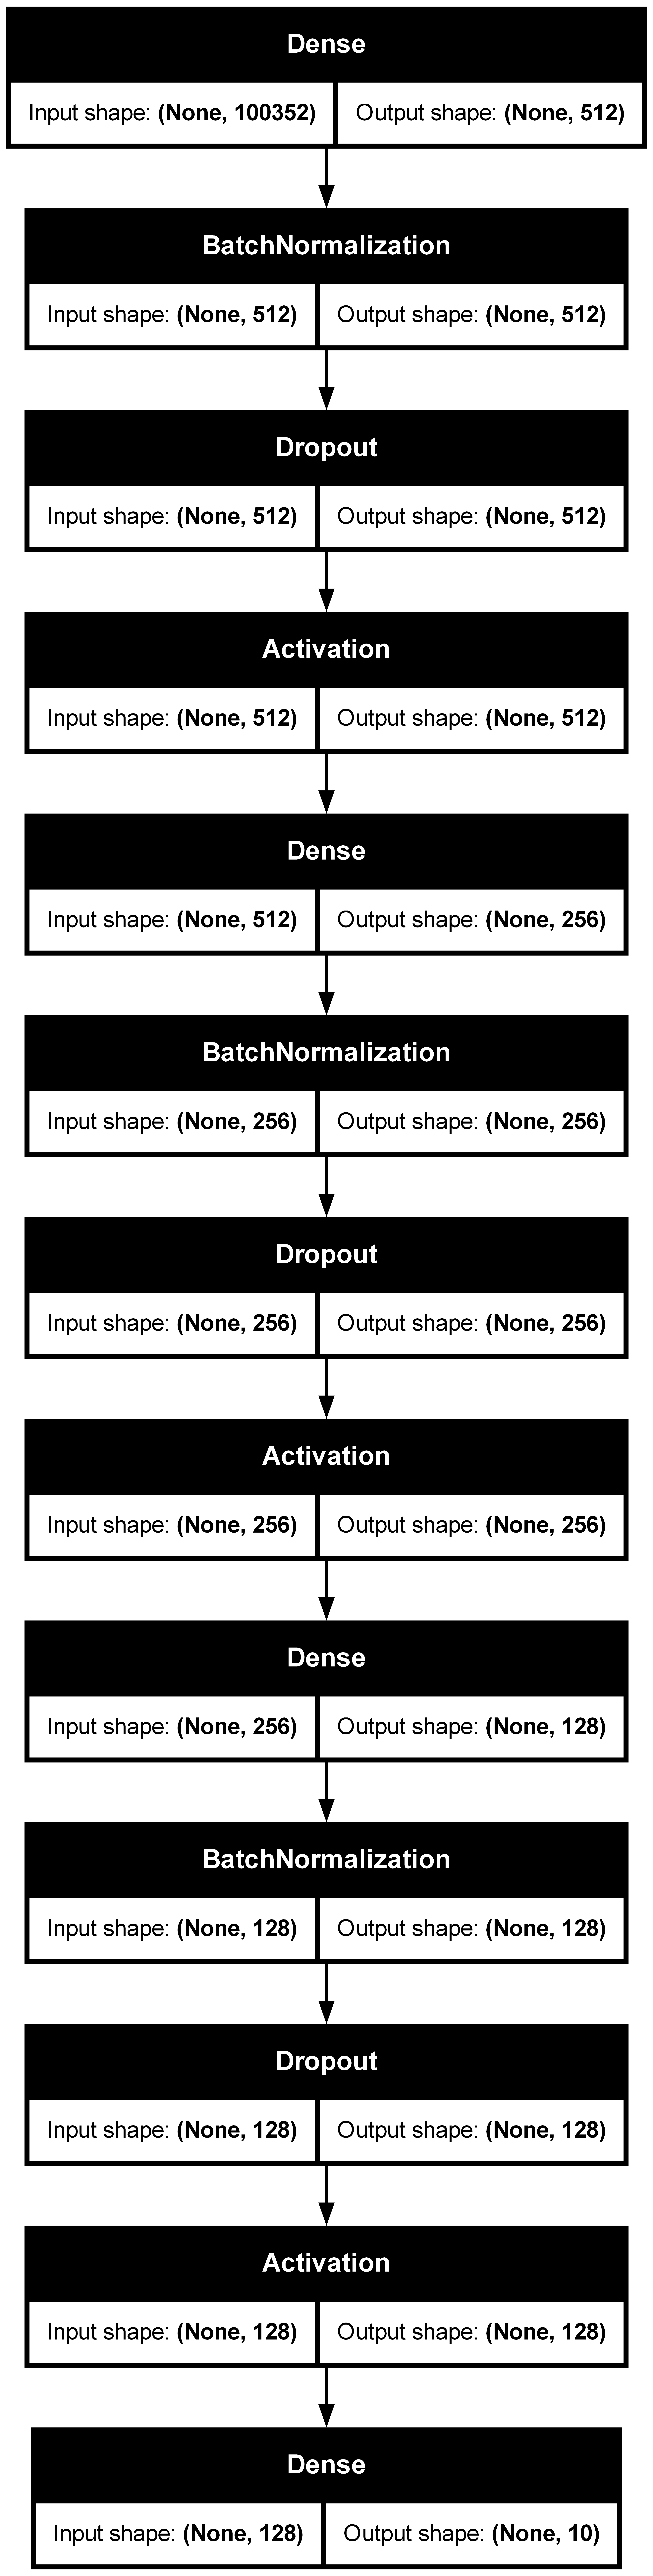

In [8]:
from tensorflow.keras.utils import plot_model

# Assuming you have your model loaded
plot_model(loaded_model, to_file='model_plot.png', show_shapes=True, dpi=600)


In [17]:
from tensorflow.keras.applications import ResNet50

# Initialize the ResNet50 model
model = ResNet50(weights='imagenet')

# Print the summary of the model
model.summary()


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [7]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8361 - loss: 2.6436
Validation Loss: 2.6033620834350586
Validation Accuracy: 0.862500011920929


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix:
[[32  0  0  0  0  0  0  0  0  1]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  0 31  0  0  1  0  0  3  3]
 [ 2  0  1 37  0  0  1  1  0  0]
 [ 3  0  0  0 35  0  3  1  0  0]
 [ 0  5  0  0  0 40  0  0  0  2]
 [ 0  0  0  0  0  0 46  0  0  1]
 [ 0  0  2  1  6  1  0 26  0  2]
 [ 4  0  0  0  4  0  0  2 24  0]
 [ 3  0  3  2  0  0  3  0  1 30]]


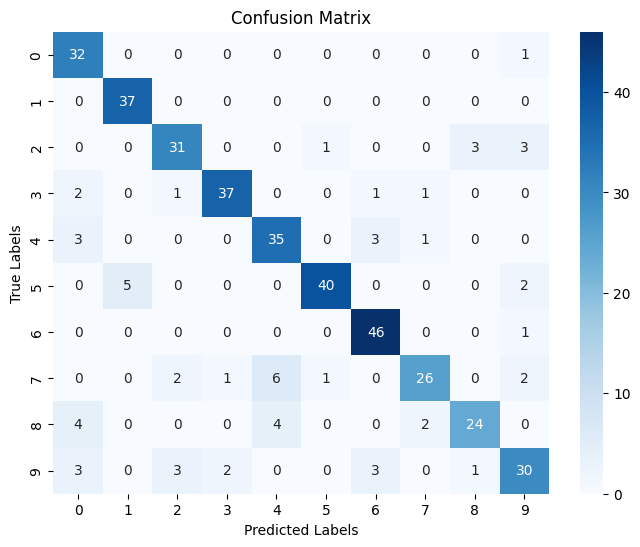

In [14]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions for the validation set
y_pred_prob = model.predict(X_val)

# Convert the probabilities to class labels (for multi-class classification)
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



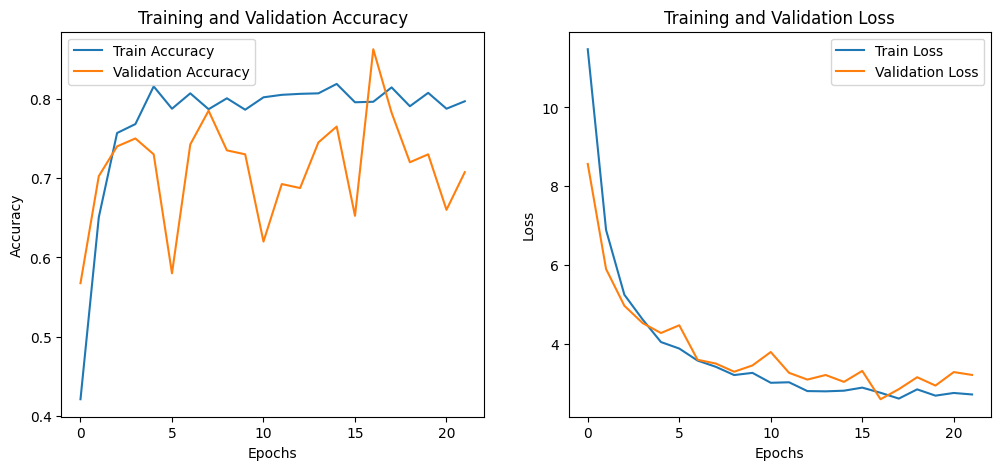

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Classification Report:
              precision    recall  f1-score   support

       Blues       0.94      0.91      0.92        33
   Classical       1.00      1.00      1.00        37
     Country       0.94      0.84      0.89        38
       Disco       0.75      0.93      0.83        42
     Hip-hop       0.84      0.90      0.87        42
        Jazz       0.94      0.94      0.94        47
       Metal       0.85      0.96      0.90        47
         Pop       0.80      0.92      0.85        38
      Reggae       1.00      0.47      0.64        34
        Rock       0.72      0.69      0.71        42

    accuracy                           0.86       400
   macro avg       0.88      0.86      0.86       400
weighted avg       0.87      0.86      0.86       400



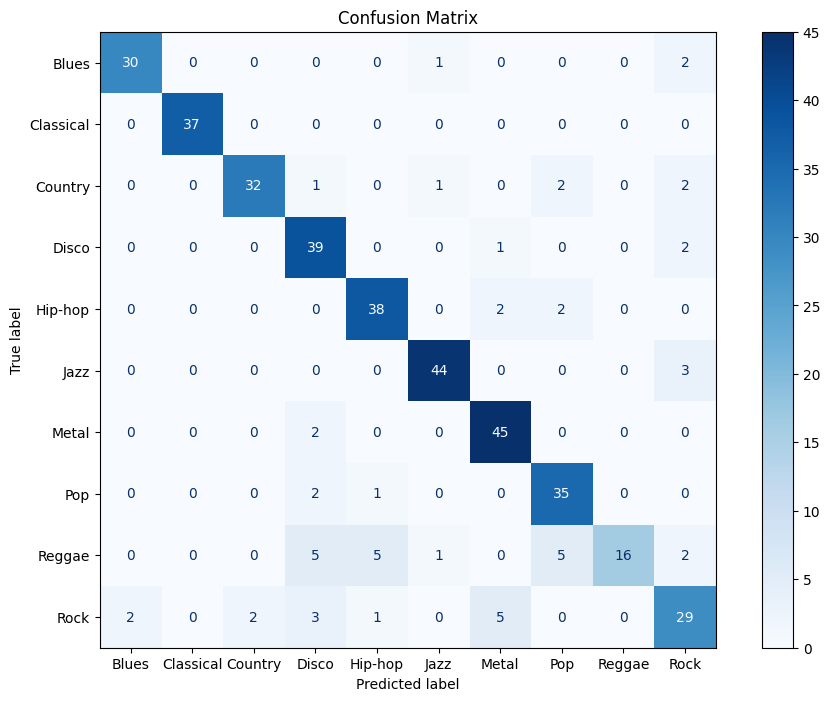

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Plot Training and Validation Accuracy/Loss
def plot_accuracy_and_loss(history):
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show()

# Classification Metrics and Confusion Matrix
def classification_metrics(model, X_val, y_val, target_names):
    # Predict the classes
    y_pred = np.argmax(model.predict(X_val), axis=-1)
    
    # Ensure y_val is in the correct format
    if len(y_val.shape) > 1:
        y_val = np.argmax(y_val, axis=-1)

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_val, y_pred, target_names=target_names))
    
    # Confusion Matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_val, y_pred)
    fig, ax = plt.subplots(figsize=(12, 8))  # Increase the width (12) and height (8)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)  # Pass ax to the plot
    plt.title("Confusion Matrix")
    plt.show()


# Example usage after model training
# Assuming history contains the training history and you have X_val, y_val ready
# Replace 'class_names' with your actual class names
plot_accuracy_and_loss(history)

# Provide your class labels for the classification report and confusion matrix
class_names = [
    'Blues', 'Classical', 'Country', 'Disco', 
    'Hip-hop', 'Jazz', 'Metal', 'Pop', 
    'Reggae', 'Rock'
]

classification_metrics(model, X_val, y_val, class_names)


In [41]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

# Path to the image you want to predict
image_path = r"F:\music genre\myenv\gram_tonegram_images\classical\classical.00001.png"

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Resize to match ResNet50's input size
img_array = image.img_to_array(img)  # Convert the image to a numpy array

# Reshape the image array to match the input shape: (1, 224, 224, 3)
img_array = np.expand_dims(img_array, axis=0)  # Adds an extra dimension to match (batch_size, height, width, channels)

# Preprocess the image for ResNet50 model
img_array = preprocess_input(img_array)

# Check the shape of the image after preprocessing
print(f"Image shape after preprocessing: {img_array.shape}")

# Load ResNet50 model to extract features
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features using ResNet50
features = resnet50_model.predict(img_array)

# Flatten the features
flattened_features = features.flatten().reshape(1, -1)

# Check the shape of the flattened features
print(f"Flattened feature shape: {flattened_features.shape}")

# Predict the class for the image using the loaded model
predictions = loaded_model.predict(flattened_features)

# If you have class names for the genres (replace this with your actual class names)
class_names = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']

# Get the predicted class index and the corresponding genre name
predicted_class_idx = np.argmax(predictions)
predicted_class = class_names[predicted_class_idx]

# Print the prediction
print(f"Predicted class: {predicted_class}")


Image shape after preprocessing: (1, 224, 224, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Flattened feature shape: (1, 100352)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted class: Classical


In [49]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your trained model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_architecture.png')


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [47]:
!pip install graphviz


Defaulting to user installation because normal site-packages is not writeable
